In [1]:
import pandas as pd
import sys
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

infolder = '/Users/irffanalahi/Research/Research_update/SoftRD/hashtable_stats/tieredApproach/Epcam_blue/EPfromserverlinecount_text'
outfol = infolder + '_figures'
files = os.listdir(infolder)
groups = '/Users/irffanalahi/Research/Research_update/SoftRD/hashtable_stats/tieredApproach/Epcam_blue/BL22EPCAM_Groups.txt'
celltypes =  '/Users/irffanalahi/Research/Research_update/SoftRD/hashtable_stats/tieredApproach/Epcam_blue/BL22EPCAM_Phenoclass_justEPCAM.txt'
if '.ipynb_checkpoints' in files:
    files.remove('.ipynb_checkpoints')

minimumTOTALcpg=250
distancefromothergroup=0.5

os.mkdir(outfol)

In [2]:
df_groups = pd.read_csv(groups, sep='\t', index_col=0, header=None)
df_groups = df_groups.T

df_cells = pd.read_csv(celltypes, sep='\t', index_col=0, header=None)
df_cells = df_cells.T

def find_owngroup(df_group, df_cell, infile):
    celltype = infile.split('_')[0]
    cell_arr = np.array(df_cell[celltype])
    idx = np.where(cell_arr == 1)[0]
    for group in df_group.columns:
        group_arr = np.array(df_group[group])
        if group_arr[idx[0]] == 1:
            return group + celltype

In [3]:
def calculateOtherVSowngroup(fname, owngroupcelltype):
    split_lst = fname.split("_")
    total = 0
    n = 0
    
    nums = [str(i) for i in list(range(0, 10))]
    
    prev='garbage'
    
    owngroupdelta=-999
    
    for split in split_lst:
        
        if "-" in split and split[-1] in nums: # confirm that the substring is a negative number
            
            if owngroupcelltype in prev:
                
                owngroupdelta=abs(float(split))
            
            else:
            
                n += 1
                total += float(split)
        else:
            prev=split
            
            
   
    avgs=abs(total / n)
    
    
    return avgs,owngroupdelta,abs(total)

def generate_df(folder, infile):
    indf = pd.read_csv(folder + '/' + infile, sep='\t')
    indf['other_group']=-999
    indf['other_group_sum']=-999  ##############
    indf['own_group']=-999
    owngroupcelltype = find_owngroup(df_groups, df_cells, infile)
    for index, row in indf.iterrows():
        r1,r2,r3=calculateOtherVSowngroup(row['Filename'], owngroupcelltype)
    
    
        indf.iloc[index,indf.columns.get_loc('other_group')]=r1
    
        indf.iloc[index,indf.columns.get_loc('own_group')]=r2
    
        indf.iloc[index,indf.columns.get_loc('other_group_sum')]=r3
        
    try1=indf[(indf['Line Count']>minimumTOTALcpg) & (indf['other_group']>distancefromothergroup)]
    percentile75=try1['Average Value'].quantile(0.75)
    outdfstep1=try1[try1['Average Value']>=percentile75]
    return outdfstep1
    
def find_min_dist(df_sub):
    x = np.array(df_sub['Average Value'])
    y = np.array(df_sub['own_group'])
    max_p = (max(x), max(y))
    min_p = (min(x), min(y))
    x_dist = max_p[0] - min_p[0]
    y_dist = max_p[1] - min_p[1]
    if x_dist == 0:
        x_dist = 1
    if y_dist == 0:
        y_dist = 1
    new_dist = np.sqrt(np.square((x - max_p[0]) / x_dist) + np.square((y - max_p[1]) / y_dist))
    idx = np.argmin(new_dist)
    return list(df_sub['Filename'])[idx]

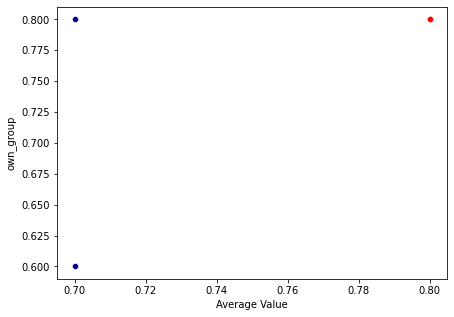

In [4]:
cell_types = []
min_files = []
for file in files:
    celltype = file.split('_')[0]
    df = generate_df(infolder, file)
    fig, ax = plt.subplots(1, 1, figsize=(7,5))
    minfile = find_min_dist(df)
    df_subset = df[df['Filename'] == minfile]
    sns.scatterplot(x='Average Value', y='own_group', color='DarkBlue', ax=ax, data=df)
    sns.scatterplot(x='Average Value', y='own_group', color='r', ax=ax, data=df_subset)
    plt.savefig(outfol + '/' + file + '_scatterplot.pdf', bbox_inches='tight')
    cell_types.append(celltype)
    min_files.append(find_min_dist(df))

In [5]:
df_dic = {'Cells':cell_types, 'Files':min_files}
df_minfiles = pd.DataFrame.from_dict(df_dic)
df_minfiles.to_csv(infolder + '_filelist.txt', sep='\t', index=None)